In [ ]:
################## Install libraries ##################

In [1]:
!pip install tiktoken --upgrade --quiet
!pip install openai --upgrade --quiet
!pip install sagemaker --upgrade --quiet
!pip install pyarrow s3fs --upgrade --quiet

In [ ]:
########### Import libraries ###########

In [1]:
import numpy as np
import pandas as pd
import boto3
import json
import os
from pandas import option_context
from typing import Union, Dict, List
import re
import logging
from tqdm import tqdm
import time
from datetime import datetime, timedelta

In [2]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [3]:
########### Sagemaker Session Validate roles  ###########

In [4]:
import sagemaker
sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")


2024-05-17 19:28:30,434 - INFO - Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


2024-05-17 19:28:30,764 - INFO - Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
2024-05-17 19:28:31,142 - INFO - Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
2024-05-17 19:28:31,334 - INFO - Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


sagemaker role arn: arn:aws:iam::730335220874:role/service-role/AmazonSageMaker-ExecutionRole-20240131T123268
sagemaker bucket: sagemaker-us-east-1-730335220874
sagemaker session region: us-east-1


In [6]:
####### Load data Trellis document data from s3 and build dataset for modeling #######

In [7]:
import zipfile
from io import BytesIO

In [11]:
from tqdm import tqdm #### progress bar

# *Function Purpose**: The `load_data_from_s3` function is designed to download our zip file provided by Trellis (Dropbox) from an S3 bucket,
# extract its contents, read text files, and load the data into a pandas DataFrame with appropriate labels.

def load_data_from_s3(bucket_name, zip_key, local_dir='/tmp/trellis_dataset'):
    """
    Downloads a zip file from S3, extracts its contents, and loads the text files into a DataFrame.
    
    Parameters:
    - bucket_name (str): The name of the S3 bucket.
    - zip_key (str): The key of the zip file in the S3 bucket.
    - local_dir (str): The local directory to extract the zip file contents.
    
    Returns:
    - pd.DataFrame: A DataFrame containing the text data and labels.
    """
    # Set up logging
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    
    try:
        logging.info("Initializing S3 client.")
        # Initialize S3 client
        s3 = boto3.client('s3')
        
        logging.info(f"Downloading zip file from S3 bucket: {bucket_name}, key: {zip_key}.")
        # Download the zip file from S3
        zip_obj = s3.get_object(Bucket=bucket_name, Key=zip_key)
        buffer = BytesIO(zip_obj['Body'].read())
        
        logging.info("Extracting zip file.")
        # Extract the zip file
        with zipfile.ZipFile(buffer, 'r') as zip_ref:
            zip_ref.extractall(local_dir)
        
        logging.info("Preparing to read text files.")
        # Prepare lists to hold data and labels
        data = []
        labels = []
        
        # Walk through the extracted directory
        for root, dirs, files in os.walk(local_dir):
            for file in tqdm(files, desc="Processing files"):
                if file.endswith('.txt'):
                    file_path = os.path.join(root, file)
                    label = os.path.basename(root)
                    
                    # Read the content of the text file
                    with open(file_path, 'r', encoding='utf-8') as f:
                        content = f.read()
                    
                    # Append the content and label to the lists
                    data.append(content)
                    labels.append(label)
        
        logging.info("Creating DataFrame.")
        # Create a DataFrame
        df = pd.DataFrame({'text': data, 'label': labels})
        
        logging.info("DataFrame created successfully.")
        return df
    
    except Exception as e:
        logging.error(f"An error occurred: {e}")
        return None

# call funcion and load the data
bucket_name = 'sagemaker-us-east-1-730335220874'
zip_key = 'trellis-dataset/trellis_assessment_ds.zip'
df = load_data_from_s3(bucket_name, zip_key)

2024-05-17 17:42:50,502 - INFO - Initializing S3 client.
2024-05-17 17:42:50,507 - INFO - Downloading zip file from S3 bucket: sagemaker-us-east-1-730335220874, key: trellis-dataset/trellis_assessment_ds.zip.
2024-05-17 17:42:50,768 - INFO - Extracting zip file.
2024-05-17 17:42:50,959 - INFO - Preparing to read text files.
Processing files: 0it [00:00, ?it/s]
Processing files: 100%|██████████| 6/6 [00:00<00:00, 13224.29it/s]
2024-05-17 17:42:51,003 - INFO - Creating DataFrame.
2024-05-17 17:42:51,004 - INFO - DataFrame created successfully.


In [13]:
print(f"the records in the data are: {df.shape[0]}")

the records in the data are: 1006


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006 entries, 0 to 1005
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1006 non-null   object
 1   label   1006 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


In [15]:
###### Quick exploration of the data ###### 

In [16]:
from pandas import option_context

with option_context('display.max_rows', None,'display.max_colwidth',200,'display.max_columns',90):
              display(df.head(2))

,text,label
0,"Lufthansa flies back to profit\n\nGerman airline Lufthansa has returned to profit in 2004 after posting huge losses in 2003.\n\nIn a preliminary report, the airline announced net profits of 400m e...",business
1,"Winn-Dixie files for bankruptcy\n\nUS supermarket group Winn-Dixie has filed for bankruptcy protection after succumbing to stiff competition in a market dominated by Wal-Mart.\n\nWinn-Dixie, once ...",business


In [17]:
from pandas import option_context

with option_context('display.max_rows', None,'display.max_colwidth',200,'display.max_columns',90):
              display(df.tail(2))

,text,label
1004,"In an inspiring display of community spirit, residents of the coastal town of Hampton Shores have launched a large-scale environmental cleanup initiative aimed at restoring the natural beauty of t...",other
1005,"This is a text with nothing to do with a common topic, this text will be used to test",other


In [18]:
from pandas import option_context

with option_context('display.max_rows', None,'display.max_colwidth',900,'display.max_columns',90):
              display(df.text.head(3))

0                                                  Lufthansa flies back to profit\n\nGerman airline Lufthansa has returned to profit in 2004 after posting huge losses in 2003.\n\nIn a preliminary report, the airline announced net profits of 400m euros ($527.61m; £274.73m), compared with a loss of 984m euros in 2003. Operating profits were at 380m euros, ten times more than in 2003. Lufthansa was hit in 2003 by tough competition and a dip in demand following the Iraq war and the killer SARS virus. It was also hit by troubles at its US catering business. Last year, Lufthansa showed signs of recovery even as some European and US airlines were teetering on the brink of bankruptcy. The board of Lufthansa has recommended paying a 2004 dividend of 0.30 euros per share. In 2003, shareholders did not get a dividend. The company said that it will give all the details of its 2004 results on 23 March.\n
1    Winn-Dixie files for bankruptcy\n\nUS supermarket group Winn-Dixie has filed for bankruptc

In [19]:
from pandas import option_context

with option_context('display.max_rows', None,'display.max_colwidth',200,'display.max_columns',90):
              display(df.label.head(3))

0    business
1    business
2    business
Name: label, dtype: object

In [20]:
###### proportion target class ###### 

In [21]:
df['label'].value_counts(normalize=False) 

label
business         100
entertainment    100
food             100
graphics         100
historical       100
medical          100
politics         100
space            100
sport            100
technologie      100
other              6
Name: count, dtype: int64

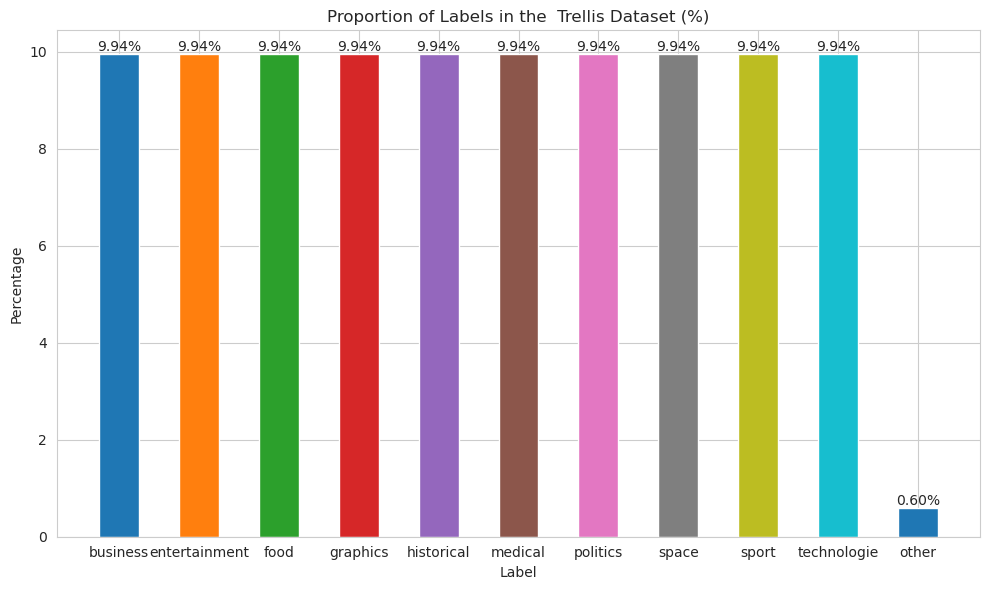

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_label_proportions_seaborn(df, column_name, bar_width=0.8):
    """
    Calculates the percentages of each unique label in the specified column of a DataFrame,
    and plots the proportions of labels in the dataset using a combination of Seaborn and Matplotlib
    for a comprehensive visualization. Allows customization of the bar width.

    Parameters:
    - df: pandas.DataFrame. The DataFrame containing the label data.
    - column_name: str. The name of the column containing the label information.
    - bar_width: float, optional. The width of the bars in the plot. Default is 0.8.
    """
    # Count the occurrences of each unique label and calculate percentages
    label_counts = df[column_name].value_counts(normalize=True).reset_index()
    label_counts.columns = ['Label', 'Percentage']
    label_counts['Percentage'] *= 100  # Convert to percentages

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    
    # Remove the grid inside the plot
    sns.despine(left=True, bottom=True)
    
    # Create a vertical bar plot
    plt.bar(label_counts['Label'], label_counts['Percentage'], 
            color=sns.color_palette("tab10", len(label_counts)), width=bar_width)
    
    plt.title('Proportion of Labels in the  Trellis Dataset (%)')
    plt.ylabel('Percentage')
    plt.xlabel('Label')

    # Adding annotations to each bar for better readability
    for index, value in enumerate(label_counts['Percentage']):
        plt.text(index, value, f"{value:.2f}%", ha='center', va='bottom')

    plt.tight_layout()  # Adjust layout to make room for the annotations
    plt.show()
    
#### call function on label colum
plot_label_proportions_seaborn(df, 'label', bar_width=0.5)

In [23]:
###### Check number of tokens for row along with min / max ###### 

In [24]:
import tiktoken

encoding = tiktoken.encoding_for_model("gpt-4-turbo")

# Define the function
def num_tokens_from_string(string: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.encoding_for_model("gpt-4-turbo-preview")
    num_tokens = len(encoding.encode(string))
    return num_tokens

from tqdm import tqdm
tqdm.pandas()

# Apply the function to the text column to count number of tokens on text 
df['text_token_count'] = df['text'].progress_apply(num_tokens_from_string)

100%|██████████| 1006/1006 [00:00<00:00, 2574.62it/s]


In [25]:
# Function to get quantiles
def get_quantiles(df, column):
    quantiles = df[column].quantile([0.02 ,0.05,.10,.20,.25, .5, 0.60,.75, 0.80, .90, 0.95,0.96,0.965,
                                     0.97,0.975, 0.985, 0.99, 1])
    return quantiles


print(get_quantiles(df, 'text_token_count'))

0.020       90.300
0.050      133.000
0.100      177.000
0.200      228.000
0.250      247.250
0.500      357.000
0.600      414.000
0.750      553.500
0.800      615.000
0.900      971.000
0.950     1634.500
0.960     1957.200
0.965     2153.375
0.970     2382.500
0.975     2550.875
0.985     3235.225
0.990     4865.800
1.000    14498.000
Name: text_token_count, dtype: float64


In [27]:
###### quick preprocessing / context lenght | remove HTML etc ###### 

In [28]:
import re
from html import unescape
from typing import Optional

In [29]:
def clean_short_or_empty_records(df: pd.DataFrame, column_name: str) -> Optional[pd.DataFrame]:
    """
    Removes rows from the DataFrame where the specified column text contains NaN values, empty strings,
    or strings with fewer than 10 characters.

    Args:
        df (pd.DataFrame): The DataFrame containing the text data.
        column_name (str): The name of the column to be cleaned.

    Returns:
        pd.DataFrame: The cleaned DataFrame with short or empty records removed, or None if an error occurred.
    """
    try:
        if df is None:
            raise ValueError("The input DataFrame is None.")
        
        if column_name not in df.columns:
            raise ValueError(f"Column '{column_name}' not found in DataFrame.")
        
        # Remove rows with NaN values in the specified column
        df = df.dropna(subset=[column_name])
        
        # Remove rows with empty strings or strings with fewer than 10 characters
        df = df[df[column_name].apply(lambda x: isinstance(x, str) and len(x.strip()) >= 10)]
        
        return df
    except Exception as e:
        logging.error(f"An error occurred while cleaning short or empty records: {e}")
        return None


# call function over text column clean_short_or_empty_records
df = clean_short_or_empty_records(df, 'text')

In [30]:
print(f"The number of rows in the current dataset df are: {df.shape[0]}")

The number of rows in the current dataset df are: 1006


In [31]:
def clean_text_content_trellis(text_content: str) -> str:
    """
    Cleans text content of  document text by performing several operations:
    - Normalizes line breaks to Unix-style.
    - Removes excessive whitespace within lines.
    - Strips HTML tags and decodes HTML entities.
    - Normalizes paragraph breaks to ensure readability.

    Args:
        text_content (str): The raw text content to be cleaned.

    Returns:
        str: The cleaned text content.
    """
    try:
        # Normalize line breaks to Unix-style
        text_content = re.sub(r'\r\n|\r', '\n', text_content)
        
        # Remove excessive whitespace within lines
        text_content = re.sub(r'\s+', ' ', text_content).strip()
        
        # Strip HTML tags and decode HTML entities
        text_content = re.sub(r'<[^>]+>', '', text_content, flags=re.DOTALL)
        text_content = unescape(text_content)
        
        # Normalize paragraph breaks to ensure readability
        text_content = re.sub(r'\n{3,}', '\n\n', text_content)
        
        return text_content
    except Exception as e:
        logging.error(f"An error occurred while cleaning the text content: {e}")
        return ""

def preprocess_text_column(df: pd.DataFrame, column_name: str) -> Optional[pd.DataFrame]:
    """
    Applies a series of preprocessing steps to clean and normalize the text content in a specified text articles column of a DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the text data.
        column_name (str): The name of the column containing the text content.

    Returns:
        pd.DataFrame: The DataFrame with the cleaned text content, or None if an error occurred.
    """
    try:
        if column_name not in df.columns:
            raise ValueError(f"Column '{column_name}' not found in DataFrame.")
        
        df[column_name] = df[column_name].apply(clean_text_content_trellis)
        return df
    except Exception as e:
        logging.error(f"An error occurred while preprocessing the text column: {e}")
        return None

# call function over text column
df = preprocess_text_column(df, 'text')

In [32]:
print(f"The number of rows in the current dataset df are: {df.shape[0]}")

The number of rows in the current dataset df are: 1006


In [33]:
from pandas import option_context

with option_context('display.max_rows', None,'display.max_colwidth',200,'display.max_columns',80):
        display(df[['text']].head(2))

,text
0,"Lufthansa flies back to profit German airline Lufthansa has returned to profit in 2004 after posting huge losses in 2003. In a preliminary report, the airline announced net profits of 400m euros (..."
1,"Winn-Dixie files for bankruptcy US supermarket group Winn-Dixie has filed for bankruptcy protection after succumbing to stiff competition in a market dominated by Wal-Mart. Winn-Dixie, once among ..."


In [34]:
# Apply the function to the 'turn_by_turn_transcript' column
df['text_token_count'] = df['text'].progress_apply(num_tokens_from_string)

100%|██████████| 1006/1006 [00:00<00:00, 2867.14it/s]


In [35]:
print(get_quantiles(df, 'text_token_count'))

0.020       81.000
0.050      120.000
0.100      162.000
0.200      214.000
0.250      235.000
0.500      346.500
0.600      405.000
0.750      541.750
0.800      608.000
0.900      942.000
0.950     1573.500
0.960     1883.000
0.965     2051.300
0.970     2195.400
0.975     2392.625
0.985     2963.900
0.990     4230.450
1.000    12736.000
Name: text_token_count, dtype: float64


In [36]:
###### remove token count data ###### 

In [37]:
def filter_by_token_count(df, column='token_count', max_token_count=1024):
    # Filter the DataFrame based on the token count
    filtered_df = df[df[column] <= max_token_count]

    # Reset the index of the filtered DataFrame
    filtered_df.reset_index(drop=True, inplace=True)

    return filtered_df

# call function 
new_df = filter_by_token_count(df, 'text_token_count', max_token_count=1024)

In [38]:
print(f"The number of rows in the current dataset df are: {new_df.shape[0]}")

The number of rows in the current dataset df are: 915


In [41]:
print(f"The number of rows in the current dataset df are: {new_df.shape[0]}")

The number of rows in the current dataset df are: 915


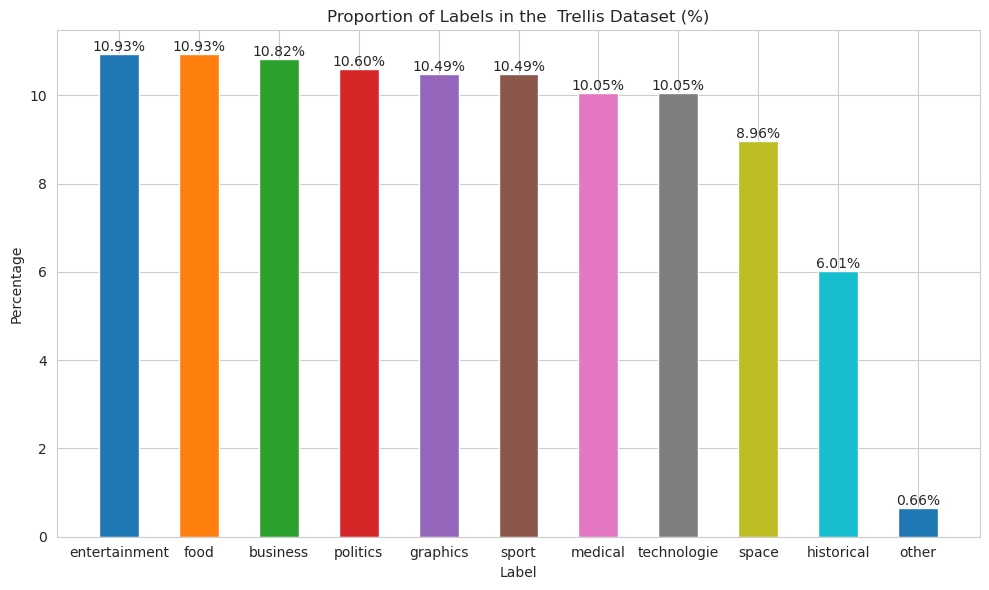

In [42]:
#### call function on label colum
plot_label_proportions_seaborn(new_df, 'label', bar_width=0.5)

In [40]:
######### encode labels  #########

In [43]:
from pandas import option_context

with option_context('display.max_rows', None,'display.max_colwidth',200,'display.max_columns',80):
        display(new_df.head(2))

,text,label,text_token_count
0,"Lufthansa flies back to profit German airline Lufthansa has returned to profit in 2004 after posting huge losses in 2003. In a preliminary report, the airline announced net profits of 400m euros (...",business,216
1,"Winn-Dixie files for bankruptcy US supermarket group Winn-Dixie has filed for bankruptcy protection after succumbing to stiff competition in a market dominated by Wal-Mart. Winn-Dixie, once among ...",business,331


In [44]:
new_df.label.unique()

array(['business', 'entertainment', 'food', 'graphics', 'historical',
       'medical', 'politics', 'space', 'sport', 'technologie', 'other'],
      dtype=object)

In [45]:
from sklearn.preprocessing import LabelEncoder
from typing import Tuple

def encode_labels(df: pd.DataFrame, column_name: str, new_column_name: str) -> Tuple[Optional[pd.DataFrame], Optional[dict]]:
    """
    Encodes the labels in the specified column of the DataFrame from 0 to n, where n is the number of unique labels minus one,
    and adds the encoded labels as a new column. Also returns a dictionary mapping original labels to encoded values.

    Args:
        df (pd.DataFrame): The DataFrame containing the label data.
        column_name (str): The name of the column containing the labels to be encoded.
        new_column_name (str): The name of the new column to store the encoded labels.

    Returns:
        Tuple[pd.DataFrame, dict]: The DataFrame with the encoded labels and the dictionary mapping original labels to encoded values,
                                   or (None, None) if an error occurred.
    """
    try:
        if column_name not in df.columns:
            raise ValueError(f"Column '{column_name}' not found in DataFrame.")
        
        # Initialize the LabelEncoder
        label_encoder = LabelEncoder()
        
        # Fit and transform the labels
        df[new_column_name] = label_encoder.fit_transform(df[column_name])
        
        # Create a dictionary mapping original labels to encoded values
        label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
        logging.info(f"Label encoding mapping: {label_mapping}")
        
        return df, label_mapping
    except Exception as e:
        logging.error(f"An error occurred while encoding labels: {e}")
        return None, None

# call function
new_df, label_mapping = encode_labels(new_df, 'label', 'encoded_label')

/tmp/ipykernel_15704/3649072570.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_column_name] = label_encoder.fit_transform(df[column_name])
2024-05-17 17:44:10,459 - INFO - Label encoding mapping: {'business': 0, 'entertainment': 1, 'food': 2, 'graphics': 3, 'historical': 4, 'medical': 5, 'other': 6, 'politics': 7, 'space': 8, 'sport': 9, 'technologie': 10}


In [51]:
print("""Label encoding mapping: {'business': 0, 'entertainment': 1, 'food': 2, 'graphics': 3, 'historical': 4, 'medical': 5, 
'other': 6, 'politics': 7, 'space': 8, 'sport': 9, 'technologie': 10}}""".strip())

Label encoding mapping: {'business': 0, 'entertainment': 1, 'food': 2, 'graphics': 3, 'historical': 4, 'medical': 5, 
'other': 6, 'politics': 7, 'space': 8, 'sport': 9, 'technologie': 10}}


In [47]:
from pandas import option_context

with option_context('display.max_rows', None,'display.max_colwidth',200,'display.max_columns',80):
        display(new_df.head(2))

,text,label,text_token_count,encoded_label
0,"Lufthansa flies back to profit German airline Lufthansa has returned to profit in 2004 after posting huge losses in 2003. In a preliminary report, the airline announced net profits of 400m euros (...",business,216,0
1,"Winn-Dixie files for bankruptcy US supermarket group Winn-Dixie has filed for bankruptcy protection after succumbing to stiff competition in a market dominated by Wal-Mart. Winn-Dixie, once among ...",business,331,0


In [48]:
new_df.columns

Index(['text', 'label', 'text_token_count', 'encoded_label'], dtype='object')

In [49]:
####### Save output data #########

In [49]:
print("Path at terminal when executing this file")
print(os.getcwd() + "\n")

Path at terminal when executing this file
/home/ec2-user/SageMaker/Trellis



In [50]:
def save_dataframe(df: pd.DataFrame, columns: list, folder_name: str, base_file_name: str) -> None:
    """
    Saves the specified columns of the DataFrame to a CSV file in the specified folder.
    If the folder does not exist, it will be created. The current date is appended to the file name.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        columns (list): The list of columns to be saved.
        folder_name (str): The name of the folder to save the file in.
        base_file_name (str): The base name of the CSV file to save.

    Returns:
        None
    """
    try:
        # Check if the specified columns exist in the DataFrame
        for column in columns:
            if column not in df.columns:
                raise ValueError(f"Column '{column}' not found in DataFrame.")
        
        # Create the folder if it does not exist
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)
            logging.info(f"Created folder: {folder_name}")
        
        # Get the current date and format it
        current_date = datetime.now().strftime("%Y-%m-%d")
        
        # Append the current date to the base file name
        file_name = f"{base_file_name}_{current_date}.csv"
        
        # Define the file path
        file_path = os.path.join(folder_name, file_name)
        
        # Save the specified columns of the DataFrame to a CSV file
        df.to_csv(file_path, columns=columns, index=False)
        logging.info(f"DataFrame saved to {file_path}")
    
    except Exception as e:
        logging.error(f"An error occurred while saving the DataFrame: {e}")

# call function to save training data
columns_to_save = ['text', 'label', 'encoded_label']
folder_name = 'training-data'
file_name = 'training_data.csv'

save_dataframe(new_df, columns_to_save, folder_name, file_name)

2024-05-17 17:44:35,333 - INFO - DataFrame saved to training-data/training_data.csv_2024-05-17.csv
